In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

In [3]:
# Verify GPU availability and clear the TensorFlow session
print("GPUs available: ", len(tf.config.experimental.list_physical_devices("GPU")))
tf.keras.backend.clear_session()

GPUs available:  1


In [5]:
# class distribution
def count_files_per_class(dataset_path):
    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            file_count = len([
                f for f in os.listdir(class_dir)
                if os.path.isfile(os.path.join(class_dir, f))
            ])
            print(f"{class_name}: {file_count} images")

# usage:
dataset_path = 'maize-detector'  
count_files_per_class(dataset_path)

0: 4582 images
1: 4565 images


In [6]:
# batching the dataset
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=321,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 9146 files belonging to 2 classes.


In [5]:
# gets the total number of batches in the dataset
len(dataset)

286

In [7]:
# split dataset into training, validation, and test sets.
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    
    #  Validate the splits
    assert (train_split + val_split + test_split) == 1, "Splits must sum to 1" 
    
    # Get the dataset size
    ds_size = ds.cardinality().numpy()
    print(f"Total dataset size: {ds_size}")
    
    # Shuffles the dataset randomly
    if shuffle:
        shuffle_size = max(shuffle_size, ds_size)
        ds = ds.shuffle(shuffle_size, seed=123)

    # Calculate partition sizes
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size) + 1
    test_size = ds_size - train_size - val_size  
    
     # Split the dataset
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

# Split the dataset
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

print(f"Training batches: {len(train_ds)}")   # Output the number of training batches
print(f"Validation batches: {len(val_ds)}")  
print(f"Testing batches: {len(test_ds)}")    

Total dataset size: 286
Training batches: 200
Validation batches: 43
Testing batches: 43


In [8]:
# data preprocessing

# resizing and normalizing pixel values
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1.0/255) # Normalizing the pixel values helps training converge faster and more accurately.
])

train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))


# data augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

train_ds = train_ds.map(augment)

# Shape of our training batch
for img, label in train_ds.take(1):  
    print("New shape:", img.shape)

New shape: (32, 224, 224, 3)


In [8]:
# model training

from tensorflow.keras import layers, models

def lightweight_maize_detector(input_shape=(224, 224, 3)):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Conv Block 1
        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(),

        # Conv Block 2
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(),

        # Conv Block 3
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(),

        # Lightweight Head
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create model
model = lightweight_maize_detector()

# Show summary
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)      

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint



# Define checkpoint callback
checkpoint = ModelCheckpoint(
    'maize_detector_V1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

# Train the model with checkpointing
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[checkpoint]  
)

Epoch 1/30
200/200 [==============================] - 125s 449ms/step - loss: 0.3825 - accuracy: 0.8406 - val_loss: 0.2573 - val_accuracy: 0.9007
Epoch 2/30
200/200 [==============================] - 107s 424ms/step - loss: 0.2658 - accuracy: 0.8947 - val_loss: 0.2204 - val_accuracy: 0.9080
Epoch 3/30
200/200 [==============================] - 93s 358ms/step - loss: 0.2283 - accuracy: 0.9089 - val_loss: 0.2187 - val_accuracy: 0.9033
Epoch 4/30
200/200 [==============================] - 90s 356ms/step - loss: 0.2015 - accuracy: 0.9196 - val_loss: 0.1786 - val_accuracy: 0.9331
Epoch 5/30
200/200 [==============================] - 95s 364ms/step - loss: 0.1744 - accuracy: 0.9311 - val_loss: 0.1238 - val_accuracy: 0.9535
Epoch 6/30
200/200 [==============================] - 114s 427ms/step - loss: 0.1634 - accuracy: 0.9361 - val_loss: 0.1137 - val_accuracy: 0.9513
Epoch 7/30
200/200 [==============================] - 94s 352ms/step - loss: 0.1511 - accuracy: 0.9395 - val_loss: 0.1280 - val

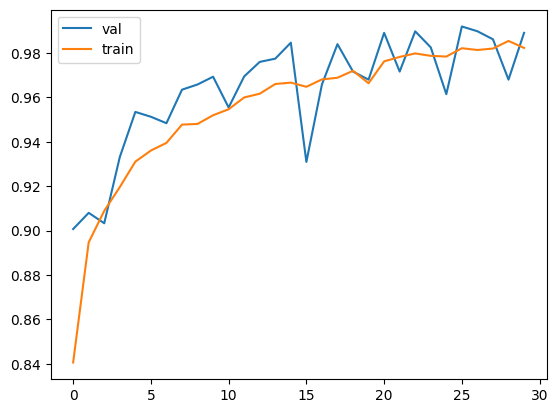

In [10]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

In [9]:
# evaluating
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras

model= keras.models.load_model('maize_detector_V1_26_0.992.h5')


# Evaluate the model on the test dataset
scores = model.evaluate(test_ds)
print("Test accuracy:", scores[1])

43/43 [==============================] - 37s 110ms/step - loss: 0.0351 - accuracy: 0.9906
Test accuracy: 0.9905523061752319


1/1 [==============================] - 1s 514ms/step


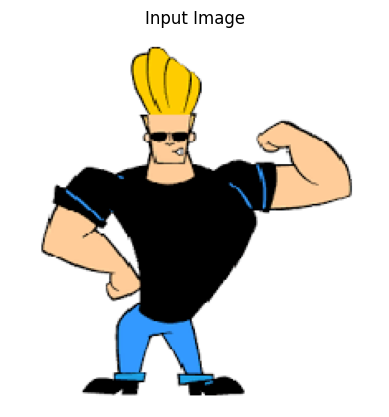

Prediction: 0 (99.62%)
Result: Not maize 🌾❌

Class probabilities:
0: 99.62%
1: 0.38%


In [11]:
from tensorflow.keras.preprocessing import image

# Constants
IMAGE_SIZE = 224
dataset_path = 'maize-detector' 
classes = os.listdir(dataset_path)
model = keras.models.load_model('maize_detector_02_0.909.h5')

def classify_image(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    img_array_normalized = img_array_expanded / 255.0

    # Predict
    prediction = model.predict(img_array_normalized)[0][0]  # Single value between 0 and 1
    predicted_class_index = int(round(prediction))  # 0 or 1
    predicted_class = classes[predicted_class_index]
    confidence_score = prediction if predicted_class_index == 1 else 1 - prediction

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Input Image", pad=10)
    plt.show()

    # Print the predicted class and interpretation
    print(f"Prediction: {predicted_class} ({confidence_score:.2%})")
    if predicted_class_index == 0:
        print("Result: Not maize 🌾❌")
    else:
        print("Result: Maize 🌽✅")

    # Print both class probabilities
    print("\nClass probabilities:")
    print(f"{classes[0]}: {(1 - prediction):.2%}")
    print(f"{classes[1]}: {prediction:.2%}")

# Example usage
img_path = r'../test-image2.png'
classify_image(img_path)